In [1]:
%reload_ext autoreload

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [763]:
from quantum_tools.examples import symbolic_contexts
from quantum_tools.symmetries.workspace import get_contraction_elements
from quantum_tools.examples.prob_dists import *
from quantum_tools.utilities.job_queuer_async import JobContext
from quantum_tools.config import *
from quantum_tools.visualization.hypergraph import *
from quantum_tools.visualization.transversal_inequalities import *
from quantum_tools.hypergraph.hypergraph_transversals import *
from quantum_tools.hypergraph.inequalities import *
from quantum_tools.contexts.measurement import *
from quantum_tools.contexts.state import *
from quantum_tools.contexts.quantum_context import *
from scipy import sparse
import numpy as np
from scipy import io
import os
from functools import reduce
from operator import mul, itemgetter

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = False

## Init Config

In [173]:
def temp_dir(name):
    return os.path.join(NOTEBOOK_FILES_DIR, 'temp', name)

In [255]:
USE_ORBITS = False
rvc = RandomVariableCollection.new(('A', 'B', 'C'), (4, 4, 4))

dimensions = 2
triangle_permutation = utils.get_triangle_permutation(dimensions)

symbolic_context = symbolic_contexts.ABC_444_444
preinjectable_sets = symbolic_context.preinjectable_sets
symbolic_context = SymbolicContext(preinjectable_sets, symbolic_context.outcomes)
infl_rvc = RandomVariableCollection.new(
    names=marginal_equality.rv_names_from_sc(preinjectable_sets),
    outcomes=symbolic_context.outcomes
)
b_string = get_preinjectablesets_latex(infl_rvc, preinjectable_sets)
duplication_map = get_duplication_map(b_string)

symbolic_context

SymbolicContext(preinjectable_sets=[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']], [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']], [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']], [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']], [['A1'], ['B3'], ['C4']], [['A1'], ['B4'], ['C2']], [['A2'], ['B1'], ['C4']], [['A2'], ['B2'], ['C2']], [['A3'], ['B3'], ['C3']], [['A3'], ['B4'], ['C1']], [['A4'], ['B1'], ['C3']], [['A4'], ['B2'], ['C1']]], outcomes=[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [5]:
row_sum, A, col_sum, contracted_A = get_contraction_elements(symbolic_contexts.ABC_444_444)
# get_contraction(infl_rvc, symbolic_contexts.ABC_444_444.preinjectable_sets)

16896 16777216
ShiftedBase(shift=0, base=(4194304, 1048576, 262144, 65536, 16384, 4096, 1024, 256, 64, 16, 4, 1))
ShiftedBase(shift=0, base=(1024, 0, 0, 256, 64, 0, 0, 16, 4, 0, 0, 1))
ShiftedBase(shift=4096, base=(1024, 0, 0, 256, 0, 64, 16, 0, 0, 4, 1, 0))
ShiftedBase(shift=8192, base=(0, 1024, 256, 0, 0, 64, 16, 0, 4, 0, 0, 1))
ShiftedBase(shift=12288, base=(0, 1024, 256, 0, 64, 0, 0, 16, 0, 4, 1, 0))
ShiftedBase(shift=16384, base=(16, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1))
ShiftedBase(shift=16448, base=(16, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0))
ShiftedBase(shift=16512, base=(0, 16, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1))
ShiftedBase(shift=16576, base=(0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0))
ShiftedBase(shift=16640, base=(0, 0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0))
ShiftedBase(shift=16704, base=(0, 0, 16, 0, 0, 0, 0, 4, 1, 0, 0, 0))
ShiftedBase(shift=16768, base=(0, 0, 0, 16, 4, 0, 0, 0, 0, 0, 1, 0))
ShiftedBase(shift=16832, base=(0, 0, 0, 16, 0, 4, 0, 0, 1, 0, 0, 0))
Found 450 row_orbits.
Found 358120 col_o

In [6]:
if USE_ORBITS:
    target_A = contracted_A.copy()
    target_A.data.fill(1) # Unitize
    orbit_contractor = row_sum
    def hg_remove(ant):
        return [ant]
else:
    target_A = A
    orbit_contractor = None
    def hg_remove(ant):
        return duplication_map[b_string[ant]]

In [7]:
target_A = sparse.csr_matrix(target_A) # Best format for computing the hypergraphs
target_A_format_cache = {
    'csc': sparse.csc_matrix(target_A),
    'csr': sparse.csr_matrix(target_A),
}

In [8]:
preinjectable_sets

[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']],
 [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']],
 [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']],
 [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']],
 [['A1'], ['B3'], ['C4']],
 [['A1'], ['B4'], ['C2']],
 [['A2'], ['B1'], ['C4']],
 [['A2'], ['B2'], ['C2']],
 [['A3'], ['B3'], ['C3']],
 [['A3'], ['B4'], ['C1']],
 [['A4'], ['B1'], ['C3']],
 [['A4'], ['B2'], ['C1']]]

# Optimization Pipeline

1. Params ✓
1. Measurement Operators, States ✓
1. QuantumContext ✓
1. Probability Distribution ✓
1. Marginal Factorized Context Vector ✓
1. Row Sum Contraction ✓
1. Hypergraph Selection Contraction ✓
1. Antecedent, Consequent Selection ✓
1. Inequality Evaluation ✓

## Finding The Party Invariant Deflated Terms

In [509]:
def get_party_symmetric_deflated_terms():
    num_outcomes = 4
    string_invariants = []
    top = 'P(A_{0}B_{0}C_{0})P(A_{1}B_{1}C_{1})'
    bottom = 'P(A_{0})P(B_{0})P(C_{0})'
    for i, j in product(range(num_outcomes), range(num_outcomes)):
        string_invariants.append(top.format(i, j))
    
    for i in range(num_outcomes):
        string_invariants.append(bottom.format(i))
    
    party_invariant_terms = [duplication_map[si] for si in string_invariants]
    
    party_invariant_terms = sorted(utils.flatten(party_invariant_terms))
        
    return party_invariant_terms
    
party_invariant_terms = get_party_symmetric_deflated_terms()

## Hypergraph Config (*Plots the hypergraph that is currently being tested against*)

<IPython.core.display.Javascript object>


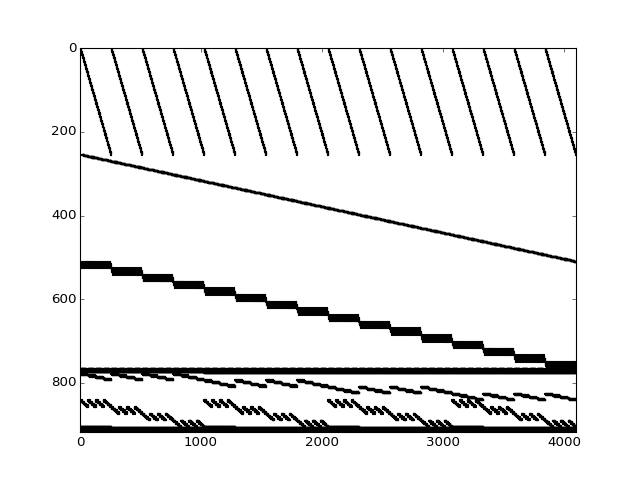

In [9]:
# THIS IS THE GLOBAL ANTECEDENT
g_antecedent = 0 # 4*(4**(2*3)) + 0
g_hg_rows, g_hg, g_hg_cols = hyper_graph(target_A_format_cache, g_antecedent, remove=hg_remove(g_antecedent))
plot_hypergraph(g_hg)

## Iterate Over Found Transversal Indices

In [9]:
def ifi(fts):
    for i in range(fts.shape[1]):
        yield fts.indices[fts.indptr[i]:fts.indptr[i+1]]

## Weighted Filtering

In [632]:
def filter_against_target(b, antecedent, hg_rows):
    
    antecedent_value = b[antecedent] # The lhs of the inequality
    marginals_hg_space = b[hg_rows] # The marginals in the space of the hypergraph (values on nodes)
    
    def target_filter(wt_indices):
        """
        wt: The working transversal to consider filtering out
        """
        consequent_values = marginals_hg_space[wt_indices] # The values of the particular consequents
        target = np.sum(consequent_values, axis=0) - antecedent_value # This value *should* be positive if no hardy paradox
#         print(target)
        return target > -1e-6

    return target_filter

## Actually Compute Transversals

In [66]:
# Studying strat objects
example_strat = TransversalStrat(
    search_type='depth',
    find_up_to=20,
    node_brancher={
        'name': 'greedy',
        'max': 4,
#         'shuffle' : True,
    }
)

example_strat

In [68]:
# Do the transversal

def do_transversal(fts, batch_size, num_batches):
    starting_size = 0 if fts is None else fts.shape[1]
    ending_size = starting_size + batch_size * num_batches
    i = starting_size
    while i < ending_size:
#         print('i is currently:', i)
        batch_strat = TransversalStrat(
            search_type='depth',
#             breadth_cap=5,
#             filter_out=filter_against_target(fritz_dist, g_antecedent, g_hg_rows),
            find_up_to= i + batch_size,
            node_brancher={
#                 'name': 'greedy',
#                 'max': 10,
                'shuffle' : True,
            }
        )
        fts = find_transversals(g_hg, strat=batch_strat, log_wt=False, log_ft=False, fts=fts)
        if fts is None:
            break
        i = fts.shape[1]
    return fts

fts = do_transversal(None, 1, 1)

# minimalized_fts = HGT.make_minimal(hg, fts)
# fts = minimalized_fts
fts

<917x1 sparse matrix of type '<class 'numpy.int16'>'
	with 29 stored elements in Compressed Sparse Column format>

## Trying Out Custom Distributions

In [698]:
def get_measurement_collection():

    ei = utils.ei
    pi = np.pi
    # Eigenvectors of sigma_x
    e_x_0 = (qb0 + qb1)/(sqrt2)
    e_x_1 = (-qb0 + qb1)/(sqrt2)
    # Eigenvectors of sigma_y
    e_y_0 = (i*qb0 + qb1)/(sqrt2)
    e_y_1 = (-i*qb0 + qb1)/(sqrt2)
    # Eigenvectors of -(sigma_y + sigma_x)/sqrt2
    e_yx_0 = (ei(-3/4*pi)*qb0 + qb1)/(sqrt2)
    e_yx_1 = (ei(1/4*pi)*qb0 + qb1)/(sqrt2)
    # Eigenvectors of (sigma_y - sigma_x)/sqrt2
    e_xy_0 = (ei(-1/4*pi)*qb0 + qb1)/(sqrt2)
    e_xy_1 = (ei(-5/4*pi)*qb0 + qb1)/(sqrt2)

    rho0 = utils.ket_to_dm(qb0)
    rho1 = utils.ket_to_dm(qb1)
    
    measurements = [
        [
            utils.tensor(rho0, rho1),
            utils.tensor(rho0, rho0),
            utils.tensor(rho1, rho1),
            utils.tensor(rho1, rho0),
        ],
        [
            utils.tensor(rho1, utils.ket_to_dm(e_y_0)),
            utils.tensor(rho1, utils.ket_to_dm(e_y_1)),
            utils.tensor(rho0, utils.ket_to_dm(e_x_1)),
            utils.tensor(rho0, utils.ket_to_dm(e_x_0)),
        ],
        [
            utils.tensor(utils.ket_to_dm(e_xy_0), rho0),
            utils.tensor(utils.ket_to_dm(e_xy_1), rho0),
            utils.tensor(utils.ket_to_dm(e_yx_0), rho1),
            utils.tensor(utils.ket_to_dm(e_yx_1), rho1),
        ],
    ]
    return measurements

def custom_q_distro():
    measurements = get_measurement_collection()
    A = Measurement(measurements[0])
#     B = Measurement(itemgetter(0,2,1,3)(measurements[0])) # Turn this on to show closeness to fritz
    B = Measurement(measurements[0])
    C = Measurement(measurements[0])
    
    rhoAB = State.Strats.Deterministic.mebs(1)
    rhoBC = State.Strats.Deterministic.mebs(2)
    rhoAC = State.Strats.Deterministic.mebs(3)

    qc = QuantumContext(
        random_variables=rvc,
        measurements=(A,B,C),
        states=(rhoAB,rhoBC,rhoAC),
        permutation=triangle_permutation,
    )
    print(qc)
#     print([isinstance(m, ProjectiveMeasurement) for m in qc.measurements])
    pd = QuantumProbDist(qc)

    return pd
custom_dist = custom_q_distro()

QuantumContext: 3 measurements, 3 states.
Number of Outcomes: 4
Size of Operators: 4
Operators:
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
Number of Outcomes: 4
Size of Operators: 4
Operators:
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
[[ 0

<IPython.core.display.Javascript object>


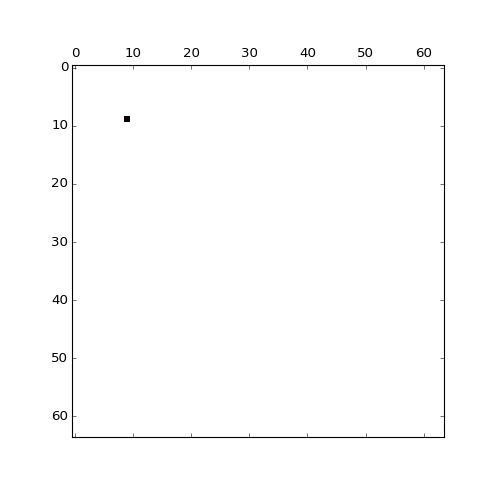

In [545]:
measurements = get_measurement_collection()[0]

plt.matshow(utils.tensor(measurements[0], measurements[2], measurements[1]).real, cmap='hot_r')

<IPython.core.display.Javascript object>


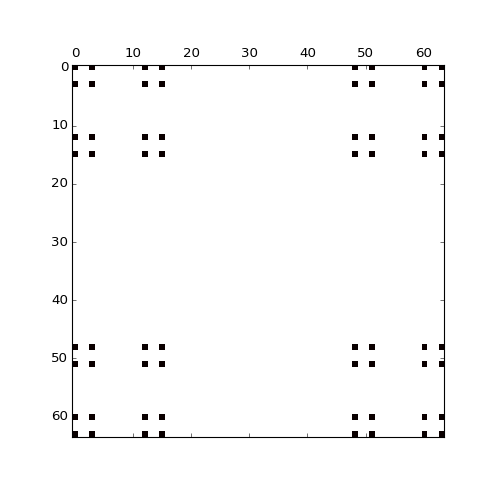

In [528]:
plt.matshow(utils.tensor(x, x, x).real, cmap='hot_r')

<IPython.core.display.Javascript object>


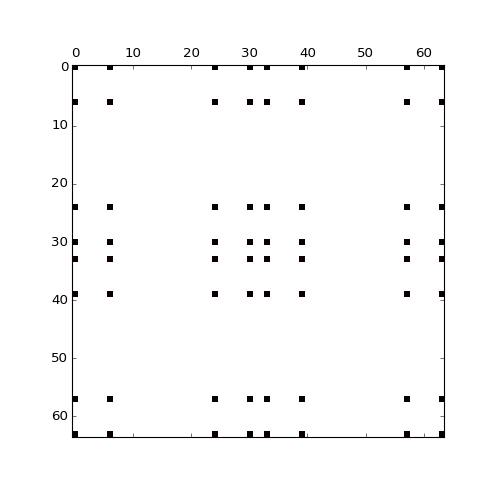

In [529]:
plt.matshow(utils.multidot(triangle_permutation.T, utils.tensor(x, x, x), triangle_permutation).real, cmap='hot_r')

In [511]:
how_much_CHSH_violation(custom_dist)

CHSH: <A0B0> + <A0B1> + <A1B0> - <A1B1> = 0.0 + 0.0 + 0.0 - 0.0 = 0.0


'CHSH = 0.0'

In [518]:
custom_support = np.array(
      [[[ 0.10669,  0.     ,  0.     ,  0.     ],
        [ 0.01831,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.10669,  0.     ],
        [ 0.     ,  0.     ,  0.01831,  0.     ]],

       [[ 0.10669,  0.     ,  0.     ,  0.     ],
        [ 0.01831,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.10669,  0.     ],
        [ 0.     ,  0.     ,  0.01831,  0.     ]],

       [[ 0.10669     ,  0.,  0.     ,  0.     ],
        [ 0.01831     ,  0.,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.10669     ,  0.],
        [ 0.     ,  0.     ,  0.01831     ,  0.]],

       [[ 0.01831     ,  0.,  0.     ,  0.     ],
        [ 0.10669     ,  0.,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.10669     ,  0.],
        [ 0.     ,  0.     ,  0.01831     ,  0.]]])
custom_support /= np.sum(custom_support)
custom_dist = ProbDist(rvc, custom_support)

In [733]:
custom_dist = cluster_pd(get_qcontext(qpc), bucket_factor=0.15)

In [752]:
print(custom_dist)

=== ProbDist ===
RandomVariableCollection
3 Random Variables:
Outcomes: 64 = 4^3
A -> [0, 1, 2, 3]
B -> [0, 1, 2, 3]
C -> [0, 1, 2, 3]
28 Achievable outcomes.
{outcome} -> {probability}
[0, 0, 0] -> 0.13486925972590297
[0, 1, 2] -> 0.019267037103700424
[0, 1, 3] -> 0.019267037103700424
[0, 2, 1] -> 0.019267037103700424
[0, 2, 3] -> 0.019267037103700424
[0, 3, 1] -> 0.019267037103700424
[0, 3, 2] -> 0.019267037103700424
[1, 0, 2] -> 0.019267037103700424
[1, 0, 3] -> 0.019267037103700424
[1, 1, 1] -> 0.13439782036161393
[1, 2, 0] -> 0.019267037103700424
[1, 2, 3] -> 0.019267037103700424
[1, 3, 0] -> 0.019267037103700424
[1, 3, 2] -> 0.019267037103700424
[2, 0, 1] -> 0.019267037103700424
[2, 0, 3] -> 0.019267037103700424
[2, 1, 0] -> 0.019267037103700424
[2, 1, 3] -> 0.019267037103700424
[2, 2, 2] -> 0.13383129023089874
[2, 3, 0] -> 0.019267037103700424
[2, 3, 1] -> 0.019267037103700424
[3, 0, 1] -> 0.019267037103700424
[3, 0, 2] -> 0.019267037103700424
[3, 1, 0] -> 0.019267037103700424
[

<IPython.core.display.Javascript object>


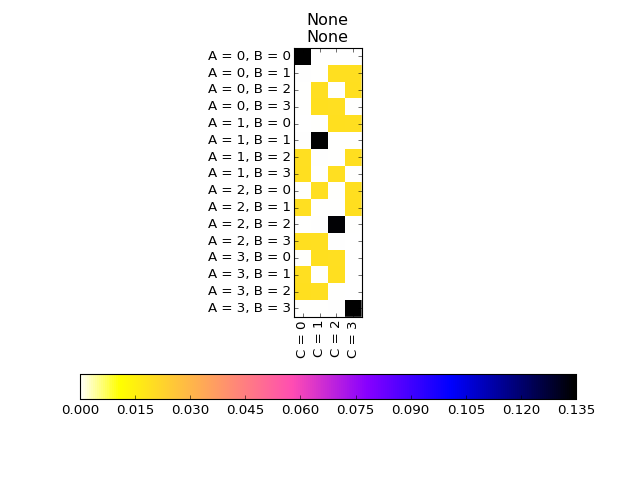

In [734]:
triangle_plot(custom_dist)

<IPython.core.display.Javascript object>


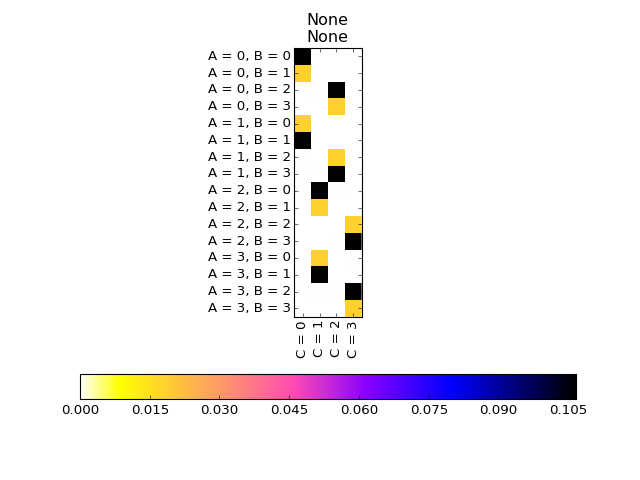

In [552]:
triangle_plot(fritz(rvc))

In [328]:
def cluster_pd(pd, bucket_factor=0.1):
    support = pd._support.copy()
    max_cs = support.max()
    min_cs = support.min()
    if min_cs < 1e-2:
        min_cs = 0.0
    num_buckets = math.ceil(1/bucket_factor)
    bucket_size = (max_cs - min_cs) / num_buckets
    buckets = np.arange(min_cs, max_cs, bucket_size)
    bucket_vals = buckets[:-1]
    for i, b in enumerate(bucket_vals):
        in_bucket = np.bitwise_and(buckets[i] <= support, support < buckets[i+1])
#         print(b)
        support[in_bucket] = b
    support /= np.sum(support)
    return ProbDist(pd._rvc, support)

## Testing Against Multiple Antecedents

In [781]:
target_dist = custom_dist
target_b = get_b(target_dist, preinjectable_sets, orbit_contractor) # The values corresponding to the preinjectable marginals
positive_antecdents = np.where(target_b >= 1e-6)[0]
bottom_antecedents = positive_antecdents[positive_antecdents >= 4*(4**(2*3))]
top_antecedents = positive_antecdents[positive_antecdents < 4*(4**(2*3))]

In [782]:
print(len(top_antecedents))
print(len(bottom_antecedents))

3136
512


In [833]:
from quantum_tools.utilities.job_queuer_async import JobContext
import sys

# antecedents = []
# antecedents = list(range(4))
# antecedents = [16384, 16385, 16386, 16387]
# antecedents = [16384]

def get_aprint(antecedent):
    def _aprint(*args):
        msg = '{:<5} :: '.format(antecedent) + ' '.join(args) + os.linesep
        sys.stdout.write(msg)
        sys.stdout.flush()
    return _aprint

def parallel_weighted_transversals(antecedents):
    target_args = [[a] for a in antecedents]
    jc = JobContext(weighted_transversal, target_args)
    jc.evaluate()
    return jc.target_results

def get_removal(antecedent):
#     duplicate_antecedents = hg_remove(antecedent)
    larger_positive_consequents = np.where(target_b >= target_b[antecedent])[0]
#     aprint('Number of duplicate antecdents: {}'.format(len(duplicate_antecedents)))
#     aprint('Number of larger possible consequents: {}'.format(len(larger_positive_consequents)))
#     remove = np.append(duplicate_antecedents, larger_positive_consequents)
    return larger_positive_consequents

def weighted_transversal(antecedent, find_up_to=1):
    aprint = get_aprint(antecedent)
    aprint('Antecedent: {}'.format(antecedent))
    remove = get_removal(antecedent)
    aprint('Number of nodes removed (including ant) {}'.format(len(remove)))
    aprint('Building Hypergraph...')
    hg_rows, hg, hg_cols = hyper_graph(target_A_format_cache, antecedent, remove=remove)
    if not transversals_exist(hg):
        aprint('No transversals to begin with.')
        return None
    aprint('Sorting nodes by target weight...')
    aprint('Sorting edges by cardinality...')
    hg_rows, hg, hg_cols = sort_hg(hg_rows, hg, hg_cols, nodes_desc=target_b)
    aprint('hg.shape: {}'.format(hg.shape))
    aprint('density(hg): {}'.format(utils.sparse_density(hg)))
    starting_transversal = (target_b[hg_rows] == 0).astype(int)
    aprint('grabbing {} nodes greedily'.format(np.sum(starting_transversal)))
#     === Node necessities is an speed up but takes a long time to compute ===
#     node_necessities = HGT.get_node_necessity(hg, get_full_transversal(len(hg_rows)))
#     aprint('{} necessary nodes'.format(len(node_necessities.necessary)))
#     for nn in node_necessities.necessary:
#         starting_transversal[nn] = 1
    aprint('starting transversal has {} nodes'.format(np.sum(starting_transversal)))
    strat = TransversalStrat(
        search_type='depth',
        # breadth_cap=5,
        filter_out=filter_against_target(target_b, antecedent, hg_rows),
        starting_transversal=starting_transversal[:, np.newaxis],
#         discontinue_branch_on_filter=True,
        find_up_to=find_up_to,
        node_brancher={
            'name': 'greedy',
            'max': 2
#             'shuffle' : True,
        }
    )
    fts = find_transversals(hg, strat=strat, log={'wt':False, 'ft':False, 'print':aprint})
    aprint('repr(fts): {}'.format(repr(fts)))
    if fts is not None:
        return {
            'antecedent':antecedent,
            'fts':fts,
            'hg_rows':hg_rows,
            'hg':hg,
            'hg_cols':hg_cols,
            'remove':remove,
        }
    return None

P(A_1)P(B_2)P(C_2)
3933 used nodes
918 unused nodes
546 unused empty nodes
372 unused non-empty nodes
Hypergraph reduced from (4851, 262144) to (372, 378)


<IPython.core.display.Javascript object>


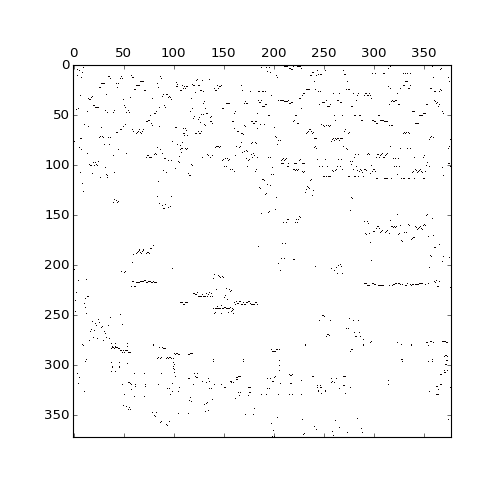

In [813]:
antecedent = 16410
print(b_string[antecedent])
hg_rows, hg, hg_cols = hyper_graph(target_A_format_cache, antecedent, remove=get_removal(antecedent))
hg_rows, hg, hg_cols = sort_hg(hg_rows, hg, hg_cols, nodes_desc=target_b)
starting_transversal = sparse.csc_matrix((target_b[hg_rows] == 0).astype(int)[:, np.newaxis])

super_reduced = perform_starting_transversal_reduction(hg, starting_transversal)
unused_nonempty_H, used_nodes, unused_nodes, unused_empty_nodes, unused_nonempty_nodes = super_reduced

antecedent_weight = target_b[antecedent]
node_weights= target_b[hg_rows][unused_nodes][unused_nonempty_nodes]

plt.matshow(unused_nonempty_H.todense(), cmap='hot_r')

In [805]:
antecedent_weight / node_weights.min()

41.900559486972362

In [832]:
antecedent_weight

0.015554272007886996

In [831]:
np.sum(node_weights[:28])

0.010394124125150329

In [828]:
np.sum(np.sort(np.array(unused_nonempty_H.sum(axis=1)).flatten())[::-1][:28])

386

In [ ]:
fts_obj = weighted_transversal(16410, 1)

16410 :: Antecedent: 16410
16410 :: Number of nodes removed (including ant) 568
16410 :: Building Hypergraph...
16410 :: Sorting nodes by target weight...
16410 :: Sorting edges by cardinality...
16410 :: hg.shape: (4851, 262144)
16410 :: density(hg): 0.0008600030921459493
16410 :: grabbing 3933 nodes greedily
16410 :: starting transversal has 3933 nodes
16410 :: 3933 used nodes
16410 :: 918 unused nodes
16410 :: 546 unused empty nodes
16410 :: 372 unused non-empty nodes
16410 :: Hypergraph reduced from (4851, 262144) to (372, 378)


In [746]:
bottom_antecedents[10:50]

array([16394, 16395, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16403, 16404, 16405, 16406, 16407, 16408, 16409,
       16410, 16411, 16412, 16413, 16414, 16415, 16416, 16417, 16418, 16419, 16420, 16421, 16422, 16423, 16424, 16425,
       16426, 16427, 16428, 16429, 16430, 16431, 16432, 16433])

In [745]:
pwt = parallel_weighted_transversals(bottom_antecedents[10:50])

JobContext requested 15 cores.
JobContext using 15 cores.
Sub-Job Finished: 2% Complete
Sub-Job Finished: 5% Complete
Sub-Job Finished: 7% Complete
Sub-Job Finished: 10% Complete
Sub-Job Finished: 12% Complete
Sub-Job Finished: 15% Complete
Sub-Job Finished: 17% Complete
Sub-Job Finished: 20% Complete
Sub-Job Finished: 22% Complete
Sub-Job Finished: 25% Complete
Sub-Job Finished: 27% Complete
Sub-Job Finished: 30% Complete
Sub-Job Finished: 32% Complete
Sub-Job Finished: 35% Complete
Sub-Job Finished: 37% Complete
Sub-Job Finished: 40% Complete
Sub-Job Finished: 42% Complete
Sub-Job Finished: 45% Complete
Sub-Job Finished: 47% Complete
Sub-Job Finished: 50% Complete
Sub-Job Finished: 52% Complete
Sub-Job Finished: 55% Complete
Sub-Job Finished: 57% Complete
Sub-Job Finished: 60% Complete
Sub-Job Finished: 62% Complete
Sub-Job Finished: 65% Complete
Sub-Job Finished: 67% Complete
Sub-Job Finished: 70% Complete
Sub-Job Finished: 72% Complete
Sub-Job Finished: 75% Complete
Sub-Job Finishe

In [743]:
found = list(filter(None, pwt))
print(len(found))
found_for_antecdents = None
if len(found) > 0:
    found_for_antecdents = [f['antecedent'] for f in found]
for f in found:
    minimalize_fts_object(f)
for f in found:
    f['violation'] = pd_to_ineq_target_from_fts_object(target_dist, f)
print(found_for_antecdents)
print([f['violation'] for f in found])

0
None
[]


In [703]:
b_string[0]

'P(A_0B_0C_0)P(A_0B_0C_0)'

In [560]:
minimalize_fts_object(found[0])

Minimalizing...
Done Minimalizing.


In [378]:
# np.savetxt(temp_dir('fritz_viable_bottom_antecedents.csv'), np.array([fts_obj['antecedent'] for fts_obj in filter(None, pwt)]))

In [182]:
valid_fritz_bottom = np.loadtxt(temp_dir('fritz_viable_bottom_antecedents.csv')).astype(int)
valid_fritz_top = np.loadtxt(temp_dir('fritz_viable_top_antecedents.csv')).astype(int)

In [561]:
output_to_ineq(found[0])

In [563]:
def minimalize_fts_object(fts_object, strat=None, force=False):
    ant     = fts_object['antecedent']
    hg_rows = fts_object['hg_rows']
    hg      = fts_object['hg']
    fts     = fts_object['fts']
    if force or 'minimal_fts' not in fts_object:
        print("Minimalizing...")
        minimal_fts = HGT.make_minimal(hg, fts, strat)
        fts_object['minimal_fts'] = minimal_fts
        print("Done Minimalizing.")

def output_to_ineq(fts_object):
    minimalize_fts_object(fts_object)
    ant     = fts_object['antecedent']
    hg_rows = fts_object['hg_rows']
    hg      = fts_object['hg']
    fts     = fts_object['fts']
    transversal_indices = list(ifi(fts_object['minimal_fts']))
    return Latex(*[transversal_inequality(ant, fts_indices, hg_rows, b_string) for fts_indices in transversal_indices])

def algebraic_equivalence(fts):
    cms = [dict(get_coeff_map(b_string, i)) for i in ifi(fts)]
    return dict_dedup(cms)

def dict_dedup(cms):
    ucms = []
    ucms_i = []
    for cm_i, cm in enumerate(cms):
        is_dup = False
        for ucm_i, ucm in enumerate(ucms):
            if cm == ucm:
                is_dup = True
                break
        if is_dup:
            ucms_i.append(ucm_i)
        else:
            ucms_i.append(len(ucms))
            ucms.append(cm)
    return ucms, ucms_i

## Visualizing Particular Transversals

In [526]:
# plot_transversals(fts)

In [527]:
# visualize_overlap(fts)

### Storing computed transversals (Evaluated Once)

In [55]:
# utils.save_sparse('ABC_444_444_A_fts_ant_30_depth_5000.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_30_depth_5000.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<920x5000 sparse matrix of type '<class 'numpy.int32'>'
	with 151351 stored elements in Compressed Sparse Column format>

In [114]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_16500.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_16500.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<920x16500 sparse matrix of type '<class 'numpy.int32'>'
	with 490799 stored elements in Compressed Sparse Column format>

In [65]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_6150_no_orbits.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_6150_no_orbits.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<917x6150 sparse matrix of type '<class 'numpy.int32'>'
	with 96148 stored elements in Compressed Sparse Column format>

In [96]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_500_orbits.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_500_orbits.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<95x450 sparse matrix of type '<class 'numpy.int32'>'
	with 5404 stored elements in Compressed Sparse Column format>

## Testing against particular distributions

In [38]:
def triangle_test(pd, log):
    targets = pd_to_ineq_target(pd, preinjectable_sets, fts, antecedent, hg_rows, multi=True, orbit_contractor=orbit_contractor)
    if np.any(targets<0):
        print("Found {} Violations".format(log))
    else:
        print("No {} Violations".format(log))
    return pd

In [22]:
triangle_test(uniform_qdistro(rvc, dimensions), 'Quantum')
triangle_test(uniform_discrete(rvc), 'Correlation')
triangle_test(c4_type(rvc), 'C4-type')
triangle_test(perfect_correlation(rvc), 'Perfect Correlation')
triangle_test(fritz(rvc), 'Fritz')
triangle_test(spekkens(rvc), 'Spekkens')

NameError: name 'fts' is not defined

## Optimizing against a Particular Inequality

In [616]:
from scipy import optimize
import multiprocessing as mp

def sym_gradient(f, x, dx):
    return (gradient(f,x,dx) + gradient(f,x,-dx)) / 2

def get_f_xdx(f, x, dx):
    f_xdx = np.zeros(f.param_size)
    for i in range(f.param_size):
        x[i] += dx
        f_xdx[i] = f(x)
        x[i] -= dx
    return f_xdx

def gradient(f, x, dx):
    return (get_f_xdx(f, x, dx) - f(x))/dx

def gradient_descent(f, x0, dx, gamma, n_max, adaptive=False):
    n = 0
    x = np.asarray(x0, dtype='float64')
    assert(f.param_size == len(x))
    h_f = np.zeros(n_max)
    h_x = np.zeros((n_max, f.param_size))
    while n < n_max:
        
        
        f_x = f(x)
        print(n, f_x, x)
        # Update History
        h_f[n] = f_x
        h_x[n, :] = x
        f_xdx = get_f_xdx(f, x, dx)
        df_x = (f_xdx - f_x)/dx
        
#         df_x[df_x > 0] = 0
        
        n += 1
        if not adaptive:
            x = x - gamma * df_x
        else:
            while True:
                x_new = x - gamma * df_x
                f_x_new = f(x_new)
                
                delta_f = f_x - f_x_new
                if delta_f >= -0.001: # Previous value greater
                    gamma *= math.exp(delta_f) # Get Larger
                    break
                else:                    
                    if gamma < 1e-5:
                        break
                    gamma *= math.exp(delta_f) # Get Smaller
            x = x_new
    return h_f, h_x
#     print(mx)
#     return x

# PROFILE_MIXIN(gradient_descent, f, x0, 0.01, 0.001)
# 
# print("Done")

In [619]:
# TESTING GRADIENT DESCENT
h_f, h_x = gradient_descent(Fxy, [1, 1], 0.01, 0.1, 100, adaptive=True)

0 -0.10392999507424829 [ 1.  1.]
1 -0.185084273284116 [ 1.08912  0.95947]
2 -0.2227810028600236 [ 1.15931  0.94863]
3 -0.2442175995449149 [ 1.2041   0.96796]
4 -0.2669114651230046 [ 1.23971  1.00133]
5 -0.293816971558092 [ 1.27653  1.04034]
6 -0.32620307038745544 [ 1.31785  1.08331]
7 -0.3656345957391305 [ 1.36518  1.13047]
8 -0.41413594050603103 [ 1.42003  1.18244]
9 -0.47419045511179664 [ 1.48433  1.23982]
10 -0.5484285714331761 [ 1.56047  1.30295]
11 -0.6384526170376158 [ 1.65091  1.37155]
12 -0.7417952288995283 [ 1.75697  1.44385]
13 -0.8466994752778007 [ 1.87516  1.51573]
14 -0.9306007477279906 [ 1.99182  1.57987]
15 -0.9762906654068487 [ 2.08391  1.62642]
16 -0.9923826986745579 [ 2.13559  1.65423]
17 -0.991386727896169 [ 2.16477  1.65021]
18 -0.9903868788169141 [ 2.15129  1.68457]
19 -0.9894022244654928 [ 2.16976  1.64842]
20 -0.995495355483508 [ 2.15742  1.67706]
21 -0.9945037542016352 [ 2.16813  1.65692]
22 -0.997243354553885 [ 2.16198  1.67207]
23 -0.9964199168441916 [ 2.1677 

In [39]:
def triangle_plot(pd, title=None, subtitle=None):
    tall_support = pd._support.reshape((16,4))
    plt.figure()
    im = plt.imshow(tall_support, cmap='gnuplot2_r', interpolation='none')
    plt.title('{}\n{}'.format(title, subtitle))
    plt.xticks(range(tall_support.shape[1]), ['C = {}'.format(i) for i in range(4)], rotation='vertical')
    plt.yticks(range(tall_support.shape[0]), ['A = {}, B = {}'.format(i, j) for i, j in product(range(4), range(4))], rotation='horizontal')
    plt.colorbar(im, orientation='horizontal')
    plt.show()

In [40]:
def how_much_CHSH_violation(pd):
    pd.update_correlation_settings({'method': 'same', 'mod': 2})
    CHSH = [
         pd.condition({'C': 0}).correlation(['A', 'B']), 
         pd.condition({'C': 1}).correlation(['A', 'B']),
         pd.condition({'C': 2}).correlation(['A', 'B']), 
         pd.condition({'C': 3}).correlation(['A', 'B']),
    ]
    terms = '<A0B0> + <A0B1> + <A1B0> - <A1B1> = {:.3} + {:.3} + {:.3} - {:.3}'.format(*CHSH)
    
    CHSH_value = sum(CHSH[0:3]) -CHSH[-1]
    print("CHSH: {} = {}".format(terms, CHSH_value))
    return "CHSH = {:.4}".format(CHSH_value)

In [43]:
def stochastic_jump(x, scale_std=0.001):
    norm_x = np.linalg.norm(x)
    delta_x = np.random.normal(0.0, norm_x * scale_std, x.shape)
    return x + delta_x

In [719]:
fritz_param = np.array([ 0.     ,  0.     , -0.70711,  0.70711,  0.     ,  0.     ,  0.70711,  0.70711,  0.     ,  0.     , -0.     ,
        0.     ,  0.70711,  0.70711,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.70711, -0.70711,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.5    ,
       -0.5    ,  0.     ,  0.     ,  0.     , -0.     , -0.5    ,  0.5    ,  0.70711,  0.70711,  0.     ,  0.     ,
        0.     ,  0.     ,  0.70711,  0.70711, -0.5    ,  0.5    , -0.     ,  0.     ,  0.     ,  0.     , -0.5    ,
        0.5    ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  1.     ,
        0.     ,  0.     ,  1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  1.     ,  0.     ,
        0.     ,  1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     , -0.70711,  0.     ,  0.70711,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.70711,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.70711,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.70711,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.70711])
qx_best = np.array([-0.0011 ,  0.00121, -0.721  ,  0.70711, -0.00196, -0.00206,  0.69185,  0.70711, -0.04258, -0.     , -0.00002,
       -0.     ,  0.70875,  0.70713, -0.00006, -0.     , -0.00208,  0.00196, -0.02964, -0.     ,  0.0014 ,  0.00125,
       -0.02838, -0.     ,  0.7016 , -0.7071 , -0.00003, -0.     , -0.04289,  0.00001, -0.00001,  0.     ,  0.47096,
       -0.5    ,  0.00001, -0.     , -0.00025,  0.00031, -0.51023,  0.5    ,  0.70217,  0.70711,  0.00003, -0.     ,
       -0.00083, -0.0008 ,  0.71967,  0.70711, -0.53163,  0.5    ,  0.00002, -0.     ,  0.00085, -0.00084, -0.47052,
        0.5    ,  0.04095,  0.     ,  0.00001,  0.     ,  0.00029,  0.00033,  0.02864, -0.     , -0.00328,  1.     ,
        0.     , -0.     ,  1.00002,  0.     ,  0.     , -0.     ,  0.00001, -0.00141, -0.00316,  1.     , -0.00135,
        0.00001,  1.00001, -0.     ,  0.00034,  0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     ,
        0.00001,  0.00023,  0.00038, -0.     ,  0.00025,  0.00001,  0.00001, -0.     ,  0.     , -0.     , -0.00002,
       -0.00003, -0.05435,  0.01911, -0.70259, -0.07137,  0.70606,  0.00001,  0.00001, -0.00009,  0.00002,  0.00009,
       -0.00002,  0.     , -0.     ,  0.     ,  0.     ,  0.00001,  0.     ,  0.     ,  0.00001,  0.00001,  0.00001,
        0.70682,  0.     , -0.00016, -0.00052,  0.00018, -0.00054,  0.70682, -0.     , -0.00001, -0.00001, -0.00001,
       -0.00001, -0.00001, -0.00001, -0.00001, -0.00001,  0.70685, -0.00002, -0.00024, -0.00151,  0.00028, -0.00149,
       0.70684])

qpc = np.array([ 1.59703, -1.71302, -0.43798, -0.86275,  0.27337, -0.97551, -0.05303, -1.91555, -2.43552,  1.2186 , -0.02778,
        0.0237 ,  0.12989, -0.48563,  0.00757,  0.59044, -3.00288,  0.14485,  2.29697,  0.00711,  1.22354,  1.55109,
        1.95842, -0.20735,  0.94266, -1.4371 ,  1.26662,  0.16071,  0.61629, -0.65578,  1.46656, -1.25158, -0.09105,
        0.53424, -1.21531,  0.75132, -1.96073,  1.6121 ,  1.02096, -0.44695,  0.27537,  0.58996, -1.59153, -0.9584 ,
       -2.33407, -0.75042,  0.28787, -1.55964,  1.39386,  2.67109,  0.16369,  0.28141, -1.1542 ,  1.91356,  0.23989,
        1.062  , -0.38611, -0.57621, -1.381  , -1.67544,  1.98436,  1.37131,  2.05494, -0.90813, -1.43477,  0.04854,
        1.523  , -0.83135,  0.60334, -0.9108 ,  0.96931, -0.60294, -0.14187, -1.24669,  0.18597, -1.81917,  1.28001,
        1.44686,  0.29249, -0.00838,  0.10655, -1.15087,  1.54956, -1.06507,  2.01872,  1.18502,  1.98101, -0.50298,
        1.89445,  0.14249, -0.35368, -1.85925,  1.63801, -2.21694,  0.96495, -1.43036, -0.00004, -0.00007,  0.00005,
       -0.00008, -0.00058, -0.00128,  0.0008 , -0.00111,  0.00108,  1.97652,  2.04833, -0.69644,  2.63351, -1.41929,
        2.32255,  2.84351,  0.00001, -0.00002,  0.00004,  0.00002,  0.00199, -0.00007, -0.00053, -0.00091, -0.00106,
       -1.25602,  2.99187,  1.74102, -0.17229,  0.83292, -1.53537,  3.24774,  0.     ,  0.     ,  0.00001, -0.00011,
        0.02886, -0.00332,  0.11533,  0.24727,  0.27289, -0.08218,  0.36354, -3.48251,  0.35185, -1.19394,  3.28991,
        0.37487])

## Declaring the Optimization Target

In [564]:
fts_obj = found[0]

### Convex Optimization (Any Distribution)

In [218]:
f = ConvexIneqTargetCaller(fts_obj)
x0 = target_dist._support.ravel() ** (1/2)
# x0 = np.random.normal(0, 1, 64)
print(f(x0))
# print((1/4)**3 - (1/4)**2)
res = optimize.minimize(f, x0, tol=0.001, method=None)
# print(f(res['x']))
# triangle_plot(f.context(res['x']))
# gradient(f, res['x'], 1)

-0.00256583691208


### Quantum Distribution Matching

In [722]:
qpm = QuantumProbMatchCaller(perfect_correlation(rvc))
res = optimize.minimize(qpm, qpc, tol=0.0001, options={'maxiter':100})
# print(get_qcontext(fritz_param)._support)

0.3203481340010766
0.32034273533799085
0.32032290891245924
0.3203229089131534
0.32032290891063014
0.32032290891785453
0.3202825302487428
0.3202825302510066
0.3202601216214489
0.32025867952115034
0.32025867952125237
0.32025867952564346
0.3202537447713096
0.32025374477130963
0.3202537447713097
0.32024315896961597
0.3202331488609819
0.320233148863696
0.32023314886329807
0.32023169664565815
0.3202316966454283
0.32023063785585254
0.3202263109424026
0.32022477623397083
0.320224776234201
0.32022477623413753


### Quantum Inequality Violator

In [622]:
qf_cc = QuantumIneqTargetCaller(fts_obj)
# print(qf_cc(fritz_param))
qres = optimize.minimize(qf_cc, fritz_param, tol=0.001, options={'maxiter':10})

In [630]:
pd_to_ineq_target_from_fts_object(custom_dist, fts_obj)

-1.0408340855860843e-17

<IPython.core.display.Javascript object>


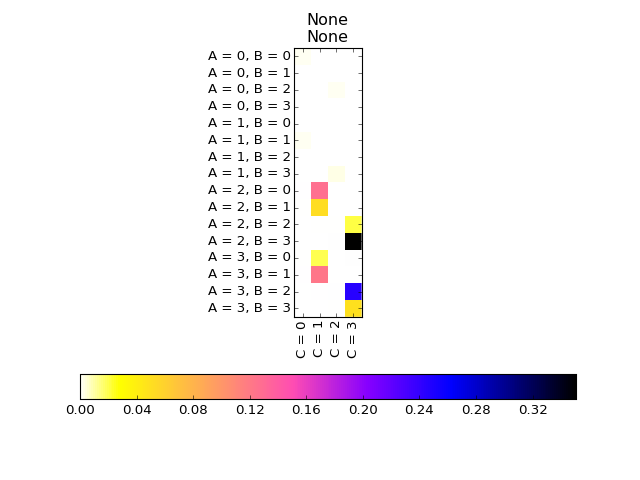

In [627]:
triangle_plot(get_qcontext(qres['x']))

### Trying to Quantumly Realize C4-Type Distributions

In [295]:
qpo = QuantumPossibilisticOptimizer(k=16)
qpres = optimize.minimize(qpo, np.random.normal(0, 1, 144), tol=0.001, options={'maxiter':10})

In [213]:
h_f, h_x = gradient_descent(f, np.random.random(), 0.001, 0.1, 0.5, 10)

In [36]:
def plot_gd(h_f):
    plt.figure()
    plt.xlabel('Gradient Descent Step')
    plt.ylabel('Inequality Target')
    plt.title('Violations')
    plt.plot(np.arange(len(h_f)), h_f)
    # plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.axis([0, len(h_f), h_f.min(), h_f.max()])
    plt.grid(True)
    plt.show()

In [684]:
class Caller():
    
    def __init__(self, f, size):
        self._f = f
        self.param_size = size
        
    def __call__(self, param):
        return self._f(*param)
    
import math
def Fxy(x, y):
    return math.sin(x**2 / 2 - y**2 / 4 + 3) * math.cos(2*x + 1 - math.e**y)

Fxy = Caller(Fxy, 2)

class ConvexIneqTargetCaller():
    
    def __init__(self, fts_obj):
        self.rvc = rvc
        self.fts_obj = fts_obj
        self.param_size = len(self.rvc.outcome_space)
        
    def __call__(self, param):
        pd = self.context(param)
        
        target = pd_to_ineq_target_from_fts_object(pd, self.fts_object)
        return target
        
    def context(self, param):
        param_shaped = param.reshape(self.rvc.outcome_space.get_input_base())
        param_shaped = param_shaped**2
        param_shaped /= np.sum(param_shaped)
        pd = ProbDist(self.rvc, param_shaped)
        return pd

parameter_desc = [32,32,32,16,16,16]
mem_slots = utils.gen_memory_slots(parameter_desc)
def get_qcontext(param):
    pA, pB, pC, prhoAB, prhoBC, prhoAC = mem_slots
    A = Measurement.Strats.Param.pvms(param[pA])
    B = Measurement.Strats.Param.pvms(param[pB])
    C = Measurement.Strats.Param.pvms(param[pC])
    rhoAB = State.Strats.Param.dm(param[prhoAB])
    rhoBC = State.Strats.Param.dm(param[prhoBC])
    rhoAC = State.Strats.Param.dm(param[prhoAC])

    qc = QuantumContext(
        random_variables=rvc,
        measurements=(A,B,C),
        states=(rhoAB,rhoBC,rhoAC),
        permutation=triangle_permutation,
    )
    pd = QuantumProbDistOptimized(qc)

    return pd

def pd_to_ineq_target_from_fts_object(pd, fts_obj):
    fts = fts_obj['minimal_fts']
    hg_rows = fts_obj['hg_rows']
    antecedent = fts_obj['antecedent']
    target = pd_to_ineq_target(
        pd,
        preinjectable_sets,
        fts,
        antecedent,
        hg_rows,
        multi=False,
        orbit_contractor=orbit_contractor
    )
    return target

class QuantumIneqTargetCaller():
    
    def __init__(self, fts_obj):
        self.fts_obj = fts_obj
        self.param_size = sum(parameter_desc)
        
    def __call__(self, param):
        pd = get_qcontext(param)

        target = pd_to_ineq_target_from_fts_object(pd, self.fts_obj)
        return target

class QuantumProbMatchCaller():
    
    def __init__(self, pd):
        self.param_size = sum(parameter_desc)
        self.pd = pd

    def __call__(self, param):
        pd = get_qcontext(param)

        target = pd_distance(self.pd, pd)
        if utils.partial_log(0.01):
            print(target)
        return target
    
class QuantumPossibilisticOptimizer():
    
    def __init__(self, k=16):
        self.param_size = sum(parameter_desc)
        self.k = k
        
    def __call__(self, param):
        pd = get_qcontext(param)
        
        flat_pd = np.sort(pd._support.ravel())
        
        desired_not_possible = flat_pd[:-self.k]
        desired_possible = flat_pd[-self.k:]
        
        dnp_norm = np.sum(desired_not_possible)/len(desired_not_possible)
        dp_norm = np.sum(desired_possible)/len(desired_possible)
        
        target = - dp_norm + dnp_norm
        
        return target
    
def pd_distance(pd_a, pd_b):
    assert(pd_a._rvc == pd_b._rvc), "Random Variables don't match."
    dist = 0.0
    for a, b in zip(pd_a.canonical_ravel(), pd_b.canonical_ravel()):
        dist += (b - a)**2
    return math.sqrt(dist)

## Archive (Sort Of)

In [29]:
import numpy as np
from quantum_tools.optimizers.minimizer import Minimizer
from quantum_tools.utilities import utils
from quantum_tools.config import *

class ConvexityMinimizer(Minimizer):

    def __init__(self, fts_obj, log=False):
        Minimizer.__init__(self, [len(rvc.outcome_space)])
        self.local_log = log
        self.rvc = rvc
        self.fts = fts_obj['minimal_fts']
        self.hg_rows = fts_obj['hg_rows']
        self.antecedent = fts_obj['antecedent']
        self.tolerance = 1e-3
        self.max_evals = 100
        self.step_size = 0.1

    def initial_guess(self):
#         initial_guess = np.random.normal(scale=10.0, size=self.mem_size)
        initial_guess = fritz(self.rvc)._support.ravel()
        return initial_guess

    def get_context(self, param):
        pAll = self.mem_slots
        param_shaped = param[pAll].reshape(self.rvc.outcome_space.get_input_base())
        param_shaped = np.abs(param_shaped, param_shaped)
        param_shaped /= np.sum(param_shaped)
        support = param_shaped
        
        return ProbDist(self.rvc, support)

    def objective(self, param):
        pd = self.get_context(param)

        target = pd_to_ineq_target(
            pd,
            preinjectable_sets,
            self.fts,
            self.antecedent,
            self.hg_rows,
            multi=False,
            orbit_contractor=orbit_contractor
        )
#         if utils.partial_log(0.01):
#             self.log("Calculated objective:", target)
        return target

In [48]:
import numpy as np
from quantum_tools.optimizers.minimizer import Minimizer
from quantum_tools.utilities import utils
from quantum_tools.config import *
from quantum_tools.contexts.measurement import Measurement
from quantum_tools.contexts.state import State
from quantum_tools.statistics.variable import RandomVariableCollection
from quantum_tools.inflation import marginal_equality
from quantum_tools.examples import symbolic_contexts
from quantum_tools.contexts.quantum_context import QuantumContext, QuantumProbDist, QuantumProbDistOptimized

class HardyOrbitMinimizer(Minimizer):

    def __init__(self, fts_obj, log=False):
        Minimizer.__init__(self, [32,32,32,16,16,16])
        self.local_log = log
        self.permutation = triangle_permutation.T
        self.rvc = rvc
        self.fts = fts_obj['minimal_fts']
        self.hg_rows = fts_obj['hg_rows']
        self.antecedent = fts_obj['antecedent']
        self.tolerance = 1e-3
        self.max_evals = 1
        self.step_size = 100

    def initial_guess(self):
        initial_guess = np.random.normal(scale=10.0, size=self.mem_size)
        return initial_guess

    def get_context(self, param):
        pA, pB, pC, prhoAB, prhoBC, prhoAC = self.mem_slots
        A = Measurement.Strats.Param.pvms(param[pA])
        B = Measurement.Strats.Param.pvms(param[pB])
        C = Measurement.Strats.Param.pvms(param[pC])
        rhoAB = State.Strats.Param.dm(param[prhoAB])
        rhoBC = State.Strats.Param.dm(param[prhoBC])
        rhoAC = State.Strats.Param.dm(param[prhoAC])

        qc = QuantumContext(
            random_variables=self.rvc,
            measurements=(A,B,C),
            states=(rhoAB,rhoBC,rhoAC),
            permutation=self.permutation,
        )
        return qc

    def objective(self, param):
        qc = self.get_context(param)
        pd = QuantumProbDistOptimized(qc)

        target = pd_to_ineq_target(
            pd,
            preinjectable_sets,
            self.fts,
            self.antecedent,
            self.hg_rows,
            multi=False,
            orbit_contractor=orbit_contractor
        )
        if utils.partial_log(.02):
            self.log("Calculated objective:", target)
        return target

In [49]:
# dimensions = 2 # Needed for computational feasibility
hom = HardyOrbitMinimizer(fts_563, log=True)
hom.minimize()
# PROFILE_MIXIN(hom.minimize)
# hom.save_results_to_file(OUTPUT_DIR + "HOM_temp.txt")

'Calculated objective:, 0.0342100318611'
'Calculated objective:, 0.0342100318668'
'Calculated objective:, 0.0210868083282'
'Calculated objective:, 0.0210868083328'
'Calculated objective:, 0.0210868083293'
'Minimize Step result: 0.021086808328141606'
'New Best Objective Result: 0.021086808328141606'
'Calculated objective:, 0.041186285575'
'Calculated objective:, 0.0411862855756'
'Calculated objective:, 0.0411862855743'
'Calculated objective:, 0.0411862855801'
'Calculated objective:, 0.041186285574'
'Calculated objective:, 0.0411862855662'
'Calculated objective:, 0.0411862855745'
'Minimize Step result: 0.035746565924410965'
'Calculated objective:, 0.0102660609065'
'Calculated objective:, 0.0102660609065'
'Calculated objective:, 0.0102660609066'
'Minimize Step result: 0.010266060906896954'
'New Best Objective Result: 0.010266060906896954'
'BH Step result: 0.010266060906896954'
'Local Minimum Accepted?: True'
'Hit max iterations.'
'Solved'


In [328]:
con_minimizer = ConvexityMinimizer(fts_563, log=True)
con_minimizer.minimize()

'BH Step result: 0.08166525898137598'
'Local Minimum Accepted?: True'
'New Best Objective Result: 0.08166525898137598'
'BH Step result: 0.07143866944623779'
'Local Minimum Accepted?: True'
'New Best Objective Result: 0.07143866944623779'
'BH Step result: 0.06835180805035077'
'Local Minimum Accepted?: True'
'New Best Objective Result: 0.06835180805035077'
'BH Step result: 0.07128338913046152'
'Local Minimum Accepted?: True'
'BH Step result: 0.06513315539339233'
'Local Minimum Accepted?: True'
'New Best Objective Result: 0.06513315539339233'
'BH Step result: 0.06666645853520983'
'Local Minimum Accepted?: True'
'BH Step result: 0.050789504033601766'
'Local Minimum Accepted?: True'
'New Best Objective Result: 0.050789504033601766'
'BH Step result: 0.05142519441257464'
'Local Minimum Accepted?: True'
'BH Step result: 0.04914076554850973'
'Local Minimum Accepted?: True'
'New Best Objective Result: 0.04914076554850973'
'BH Step result: 0.05675961208394404'
'Local Minimum Accepted?: True'
'BH 

In [197]:
# TESTING JOBCONTEXT
import time

def f(a,b,c):
#     for i in range(100000000):
#         i*i
    time.sleep(2)
    return a - b * c

def test():
    jc = JobContext(f, [[1,2,3], [2,3,4], [3,4,5], [3, 4, 5], [3, 4, 11]]*6)
    jc.evaluate()
    for result in jc.target_results:
        print(result)
test()

JobContext requested 15 cores.
JobContext using 15 cores.
Sub-Job Finished: 3% Complete
Sub-Job Finished: 6% Complete
Sub-Job Finished: 10% Complete
Sub-Job Finished: 13% Complete
Sub-Job Finished: 16% Complete
Sub-Job Finished: 20% Complete
Sub-Job Finished: 23% Complete
Sub-Job Finished: 26% Complete
Sub-Job Finished: 30% Complete
Sub-Job Finished: 33% Complete
Sub-Job Finished: 36% Complete
Sub-Job Finished: 40% Complete
Sub-Job Finished: 43% Complete
Sub-Job Finished: 46% Complete
Sub-Job Finished: 50% Complete
Sub-Job Finished: 53% Complete
Sub-Job Finished: 56% Complete
Sub-Job Finished: 60% Complete
Sub-Job Finished: 63% Complete
Sub-Job Finished: 66% Complete
Sub-Job Finished: 70% Complete
Sub-Job Finished: 73% Complete
Sub-Job Finished: 76% Complete
Sub-Job Finished: 80% Complete
Sub-Job Finished: 83% Complete
Sub-Job Finished: 86% Complete
Sub-Job Finished: 90% Complete
Sub-Job Finished: 93% Complete
Sub-Job Finished: 96% Complete
Sub-Job Finished: 100% Complete
-41
-17
-17
-

In [76]:
print(con_minimizer.best_objective_result)
print(con_minimizer.best_context)

0.062989336451
=== ProbDist ===
RandomVariableCollection
3 Random Variables:
Outcomes: 64 = 4^3
A -> [0, 1, 2, 3]
B -> [0, 1, 2, 3]
C -> [0, 1, 2, 3]
64 Achievable outcomes.
{outcome} -> {probability}
[0, 0, 0] -> 0.011958106669855471
[0, 0, 1] -> 0.02245626522877477
[0, 0, 2] -> 0.029881978519118238
[0, 0, 3] -> 0.026517741784992253
[0, 1, 0] -> 0.027748866642500848
[0, 1, 1] -> 0.006566040987675268
[0, 1, 2] -> 0.021742899742366747
[0, 1, 3] -> 0.02868217057891313
[0, 2, 0] -> 0.009682973577929268
[0, 2, 1] -> 0.012066014888521812
[0, 2, 2] -> 0.014952020989761035
[0, 2, 3] -> 0.014178990649326068
[0, 3, 0] -> 0.02086145857259367
[0, 3, 1] -> 0.0029886203193120746
[0, 3, 2] -> 0.009807733798516913
[0, 3, 3] -> 0.020630985956209276
[1, 0, 0] -> 0.027955860589235774
[1, 0, 1] -> 0.023428685895671632
[1, 0, 2] -> 0.017901920610390462
[1, 0, 3] -> 0.003992776700248639
[1, 1, 0] -> 0.023847226478860183
[1, 1, 1] -> 0.008262150979575323
[1, 1, 2] -> 0.0224170313755561
[1, 1, 3] -> 0.012687